In [1]:
from typing import List, Tuple
import copy
import numpy as np
import joblib
import time
import os
import math

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from IPython.display import Image as IPyImage
import seaborn as sns
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [3]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [4]:
class RLAgent:
    def __init__(
            self, env, num_episodes, n_training_phase=10, alpha=0.1, gamma=0.99, 
            exp_method="epsilon_greedy", epsilon=0.1,
            c=2.0, tau=0.5

        ):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        self.count_table = dict() # Store all action counts in a dictionary (for UCB)
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}
                        self.count_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.n_training_phase = n_training_phase # additional parameter to get fall-off rate per phase
        self.alpha = alpha
        self.gamma = gamma
        self.exp_method = exp_method # additional parameter to select exploration method
        self.epsilon = epsilon
        self.c = c # additional parameter for UCB
        self.tau = tau # additional parameter for boltzmann

        self.timesteps = 1 # to keep track of time steps for UCB
        
    def act(self, state, is_training = True):
        # """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        """ Returns the optimal action based on the exploration method specified."""
        ### ASSIGNMENT START
        q_values_of_state = self.q_table[state]
        count_values_of_state = self.count_table[state]

        if self.exp_method == "epsilon_greedy":
            if np.random.uniform(0,1) < self.epsilon and is_training:
                action = self.action_space[np.random.randint(0, len(self.action_space))]
            else:       
                maxValue = max(q_values_of_state.values())
                action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        elif self.exp_method == "ucb":
            if is_training:
                q_array = np.array([v for k, v in q_values_of_state.items()])
                n_array = np.array([v for k, v in count_values_of_state.items()])
                ucb_values = q_array + self.c * np.sqrt(np.log(self.timesteps + 1) / (n_array + 1e-5))
                ucb_dict = {k: v for k, v in zip(self.action_space, ucb_values)}
                maxValue = max(ucb_dict.values()) 
                action = np.random.choice([k for k, v in ucb_dict.items() if v == maxValue])
            else :
                maxValue = max(q_values_of_state.values())
                action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        elif self.exp_method == "boltzmann":
            if is_training:
                z = np.array([q_values_of_state[a] for a in self.action_space]) / self.tau
                prefs = np.exp(z - np.max(z)) # substract max for numerical stability
                action_probs = prefs / np.sum(prefs)
                action = np.random.choice(self.action_space, p=action_probs)
            else:        
                maxValue = max(q_values_of_state.values())
                action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        else :
            #if no exploration method specified, select random action
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        
        return action
    
        ### ASSIGNMENT END

    def learn(self):
        """Updates Q-values iteratively."""
        ### ASSIGNMENT START

        rewards = [] #to store the reward of each episode
        cliff_fall_frac = [] #to store the fraction of times agent/box fell off each cliff per phase

        phase_length = math.ceil(self.num_episodes / self.n_training_phase)
        total_episode_count = 0

        for phase in range(self.n_training_phase):
            phase_episode_count = 0

            #create a dict to monitor the number of times agent/box fell off each cliff cell
            cliff_fall_dict = {}
            for x in range(self.env.world_height):
                for y in range(self.env.world_width):
                    cliff_fall_dict[(x, y)] = 0

            for _ in range(phase_length): 
                # stop training if num_episodes is reached
                if total_episode_count >= self.num_episodes:
                    break

                cumulative_reward = 0 # Initialise values of each game
                state = self.env.reset()
                done = False

                while not done: # Run until game terminated
                    #Applying Q-Learning Algorithm

                    #choose A from S using policy derived from Q
                    action = self.act(state, is_training=True)

                    #take action A, observe R and S'
                    next_state, reward, done, info = self.env.step(action)

                    #update Q(S, A)
                    q_original = self.q_table[state][action]
                    q_next_state = max(self.q_table[next_state].values())
                    self.q_table[state][action] = q_original + self.alpha * (reward + (self.gamma * q_next_state) - q_original)
                    
                    #update counts and time step for UCB
                    self.count_table[state][action] += 1
                    self.timesteps += 1

                    #update cumulative reward and current state
                    cumulative_reward += reward
                    state = next_state

                rewards.append(cumulative_reward)

                #check if agent/box fell off cliff and update dict
                if self.env._check_off_cliff(self.env.agent_pos):
                    cliff_fall_dict[tuple(self.env.agent_pos)] += 1
                if self.env._check_off_cliff(self.env.box_pos):
                    cliff_fall_dict[tuple(self.env.box_pos)] += 1
                
                total_episode_count += 1
                phase_episode_count += 1

            if phase_episode_count>0:
                cliff_fall_frac.append({cell: cliff_fall_dict[cell]/phase_episode_count for cell in cliff_fall_dict})

        return rewards, cliff_fall_frac
    
        ### ASSIGNMENT END

Here is the game interface where you can manually move the agent.

In [5]:
# env = CliffBoxGridWorld(render=True)
# env.reset()
# env.print_world()
# done = False
# rewards = []

# while not done:
#     action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
#     state, reward, done, info = env.step(action)
#     rewards.append(reward)
#     print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
#     env.print_world()

# print(f'rewards: {sum(rewards)}')
# print(f'action history: {env.action_history}')

Example code to step random agent in the environment.

In [6]:
# # Initialize the environment and agent
# env = CliffBoxGridWorld()
# agent = RandomAgent(env, num_episodes=1000)
# rewards = agent.learn()

# # Plot the learning curve
# plt.plot(rewards)

Train your own agent!

In [7]:
#set run config
N_EPISODE = 15000

EXP_METHOD = "epsilon_greedy"
# EXP_METHOD = "ucb"
# EXP_METHOD = "boltzmann"

In [8]:
#prepare folder to save images
runtime_id = str(int(time.time() * 1000))
output_dir = f'output/run_{runtime_id}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    os.makedirs(output_dir+'/cliff_fall_heatmaps')
    os.makedirs(output_dir+'/learned_policy')

Success rate: 0.6275


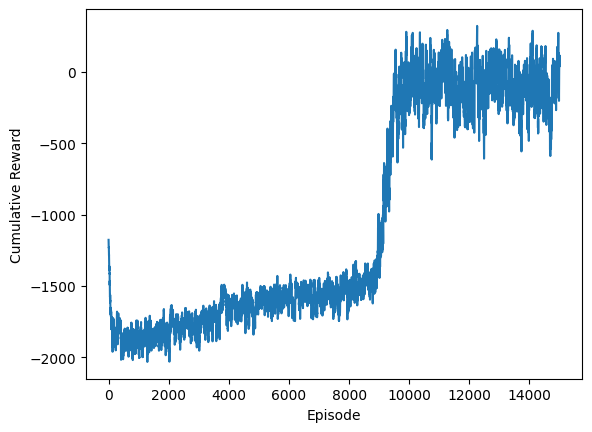

In [9]:
#train custom model
env = CliffBoxGridWorld()
n_episode = N_EPISODE
exp_method = EXP_METHOD

agent = RLAgent(env, num_episodes=n_episode, exp_method=exp_method)
rewards, cliff_fall_frac = agent.learn()

#save model
joblib.dump(agent, f"{output_dir}/rl_agent_n_episode_{n_episode}_{exp_method}.pkl")

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
# plt.title(f'Q-Learning RL Agent Learning Curve (Smoothed). \nExploration Method : {exp_method}.')
plt.savefig(f'{output_dir}/learning_curve.png', bbox_inches='tight')

You need to complete the following method to visualize your training results.

In [10]:
def visualize(q_table):
    v_table = {}
    policy = {}
    for key, v in q_table.items():
        ### ASSIGNMENT START

        v_table[key] = max(v.values()) # get the maximum Q value among all possible actions
        policy[key] = max(v, key=v.get) # get the action that has the highest Q value

        ### ASSIGNMENT END
    state_num = len(q_table.keys())
    print(f"State space: {state_num}")
    
    # Print the largest 20 state values in v_table and the corresponding policy
    for k, val in sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]:
      print("v_table", k, val / state_num)
      print("policy", k, policy[k])

def plot_state_grid(world_state, val_to_int, cmap, title, output_path):
    """
    Plot the state grid of the environment.

    Args:
        world_state : 2D array showing current state
        val_to_int : dictionary to map state values to integers
        cmap : colormap for each state
        title : plot title
        output_path : path to save the plot
    """
    #map state values to integers
    world_state_int = np.vectorize(val_to_int.get)(world_state)

    #plot the state matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(world_state_int, cmap=cmap)
    
    #plot grids
    plt.xticks(np.arange(-0.5, world_state.shape[1], 1), minor=True)
    plt.yticks(np.arange(-0.5, world_state.shape[0], 1), minor=True)
    plt.grid(which='minor', color='black', linestyle='-', linewidth=1)

    #overlay entity labels
    for i in range(world_state.shape[0]):
        for j in range(world_state.shape[1]):
            plt.text(j, i, world_state[i][j], ha="center", va="center", color="black", fontsize=14)
    
    plt.title(title)
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()

visualize(agent.q_table)

State space: 7056
v_table (2, 13, 3, 13) 0.14143990929705208
policy (2, 13, 3, 13) 2
v_table (1, 13, 2, 13) 0.1396003401360543
policy (1, 13, 2, 13) 2
v_table (1, 13, 3, 13) 0.1395987382413009
policy (1, 13, 3, 13) 2
v_table (0, 13, 1, 13) 0.1376374433106574
policy (0, 13, 1, 13) 2
v_table (0, 13, 2, 13) 0.13763697093600416
policy (0, 13, 2, 13) 2
v_table (1, 12, 2, 13) 0.13763569381510754
policy (1, 12, 2, 13) 4
v_table (0, 12, 1, 13) 0.13555245209750538
policy (0, 12, 1, 13) 4
v_table (1, 12, 1, 13) 0.13334658744047584
policy (1, 12, 1, 13) 1
v_table (0, 11, 1, 13) 0.1333462268350968
policy (0, 11, 1, 13) 4
v_table (1, 11, 1, 12) 0.13130450478602562
policy (1, 11, 1, 12) 4
v_table (1, 11, 1, 13) 0.13130273004796725
policy (1, 11, 1, 13) 4
v_table (1, 10, 1, 11) 0.1291411196021109
policy (1, 10, 1, 11) 4
v_table (0, 11, 1, 12) 0.1291395804335662
policy (0, 11, 1, 12) 2
v_table (1, 10, 1, 12) 0.12913917383741233
policy (1, 10, 1, 12) 4
v_table (2, 11, 1, 12) 0.1291294332841814
policy (


Evaluate the agent without exploration

In [11]:
# env = CliffBoxGridWorld(render=True)
# total_run = 1000
# success = 0

# for i in range(total_run):
#     state = env.reset()
#     done = False
#     rewards = []
    
#     while not done: 
#         action = agent.act(state, is_training=False)
#         next_state, reward, done, info = env.step(action)
#         state = next_state
#         rewards.append(reward)
#     if sum(rewards) > 0:
#         success += 1
# print(success/total_run)

Evaluate the agent with exploration and visualization

In [12]:
# env = CliffBoxGridWorld(render=True)
# state = env.reset()
# env.print_world()
# done = False
# rewards = []

# while not done: # Run until game terminated
#     action = agent.act(state)
#     next_state, reward, done, info = env.step(action)
#     state = next_state
#     rewards.append(reward)
#     print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
#     env.print_world()

# print(f'rewards: {sum(rewards)}')
# print(f'action history: {env.action_history}')

Plot the cliff fall-rate dynamics

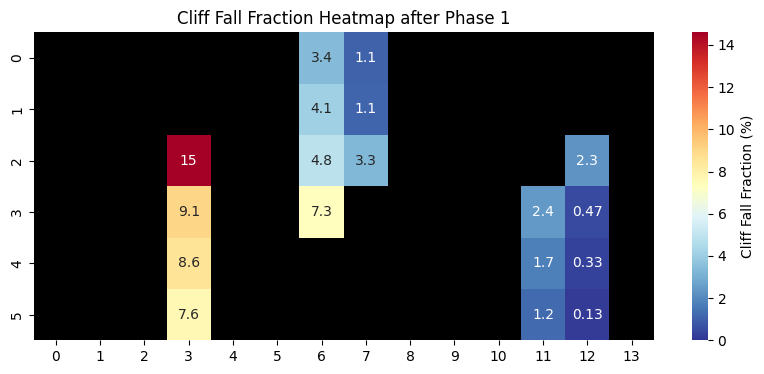

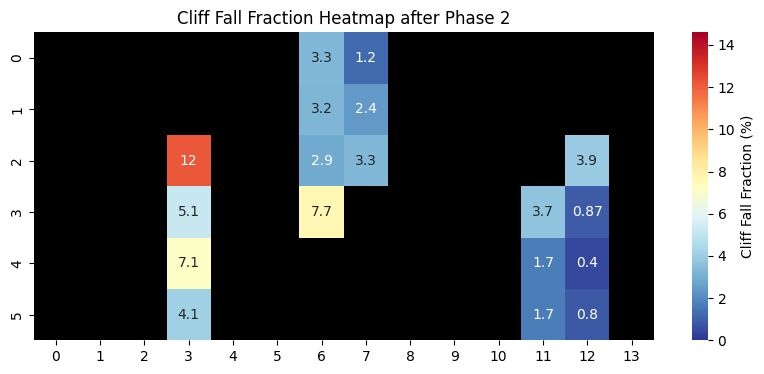

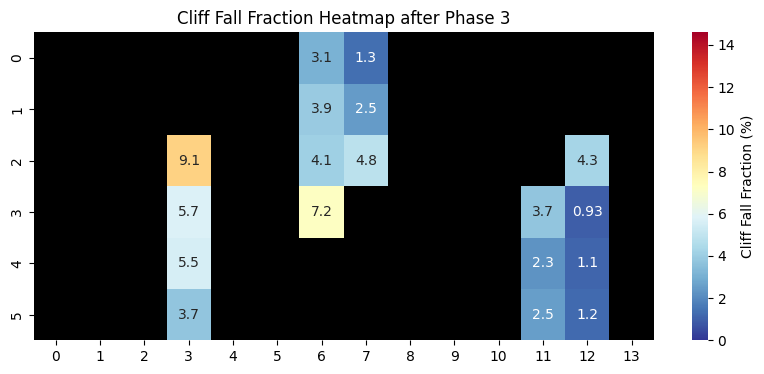

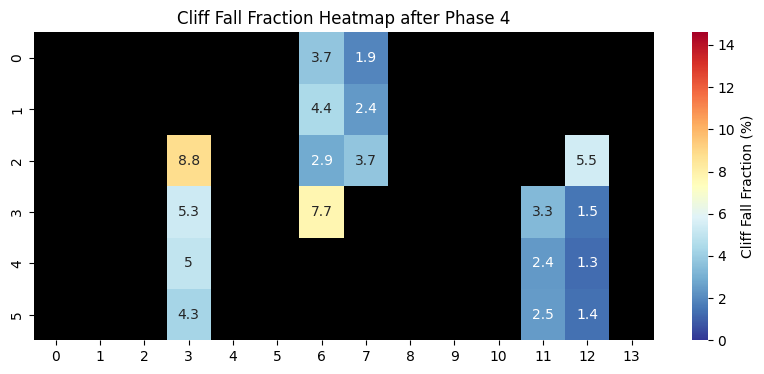

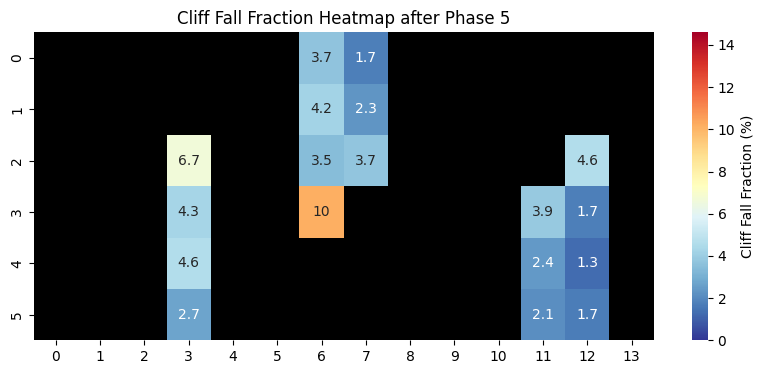

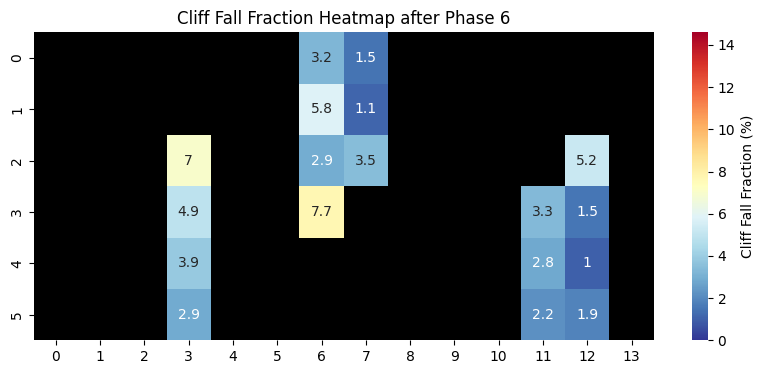

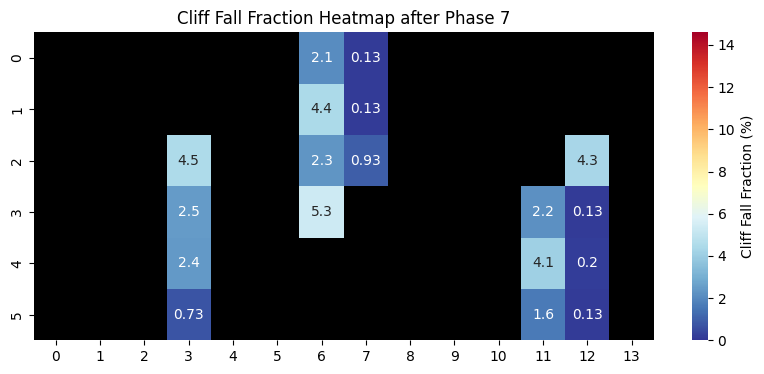

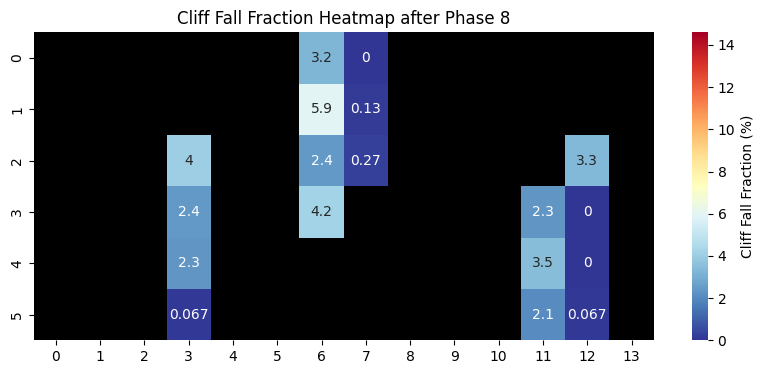

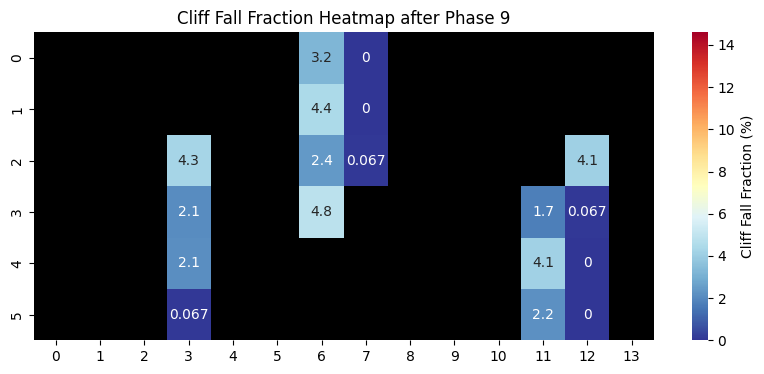

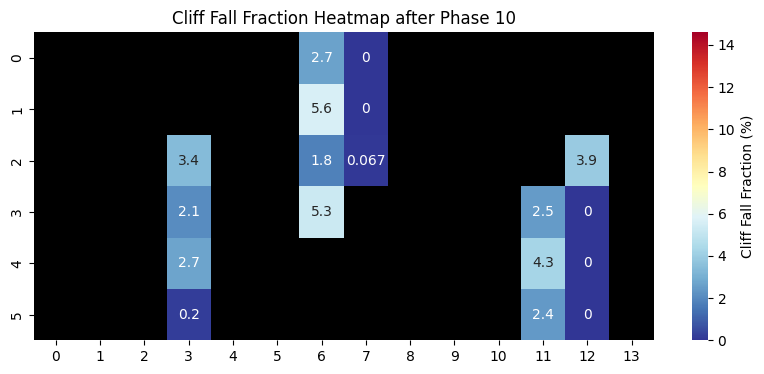

In [13]:
### ASSIGNMENT START

# Visualize cliff fall fraction heatmap
max_frac = max([max(cliff_fall_frac[i].values()) for i in range(len(cliff_fall_frac))]) * 100
for idx, frac_dict in enumerate(cliff_fall_frac):
    cliff_fall_frac_heatmap = np.zeros((env.world_height, env.world_width))*np.nan #initialize with nan for non-cliff cells
    for cell, frac in frac_dict.items():
        if env._check_off_cliff(cell):
            cliff_fall_frac_heatmap[cell] = frac * 100

    plt.figure(figsize=(10, 4))
    cmap = plt.cm.RdYlBu_r.copy()
    cmap.set_bad(color='black')  # Set color for NaN values
    sns.heatmap(cliff_fall_frac_heatmap, annot=True, vmin=0, vmax=max_frac, cmap=cmap, cbar_kws={'label': 'Cliff Fall Fraction (%)'})
    plt.title(f"Cliff Fall Fraction Heatmap after Phase {idx+1}")
    plt.savefig(f'{output_dir}/cliff_fall_heatmaps/heatmap_phase_{idx+1:03}.png', bbox_inches='tight')
    plt.show()

### ASSIGNMENT END

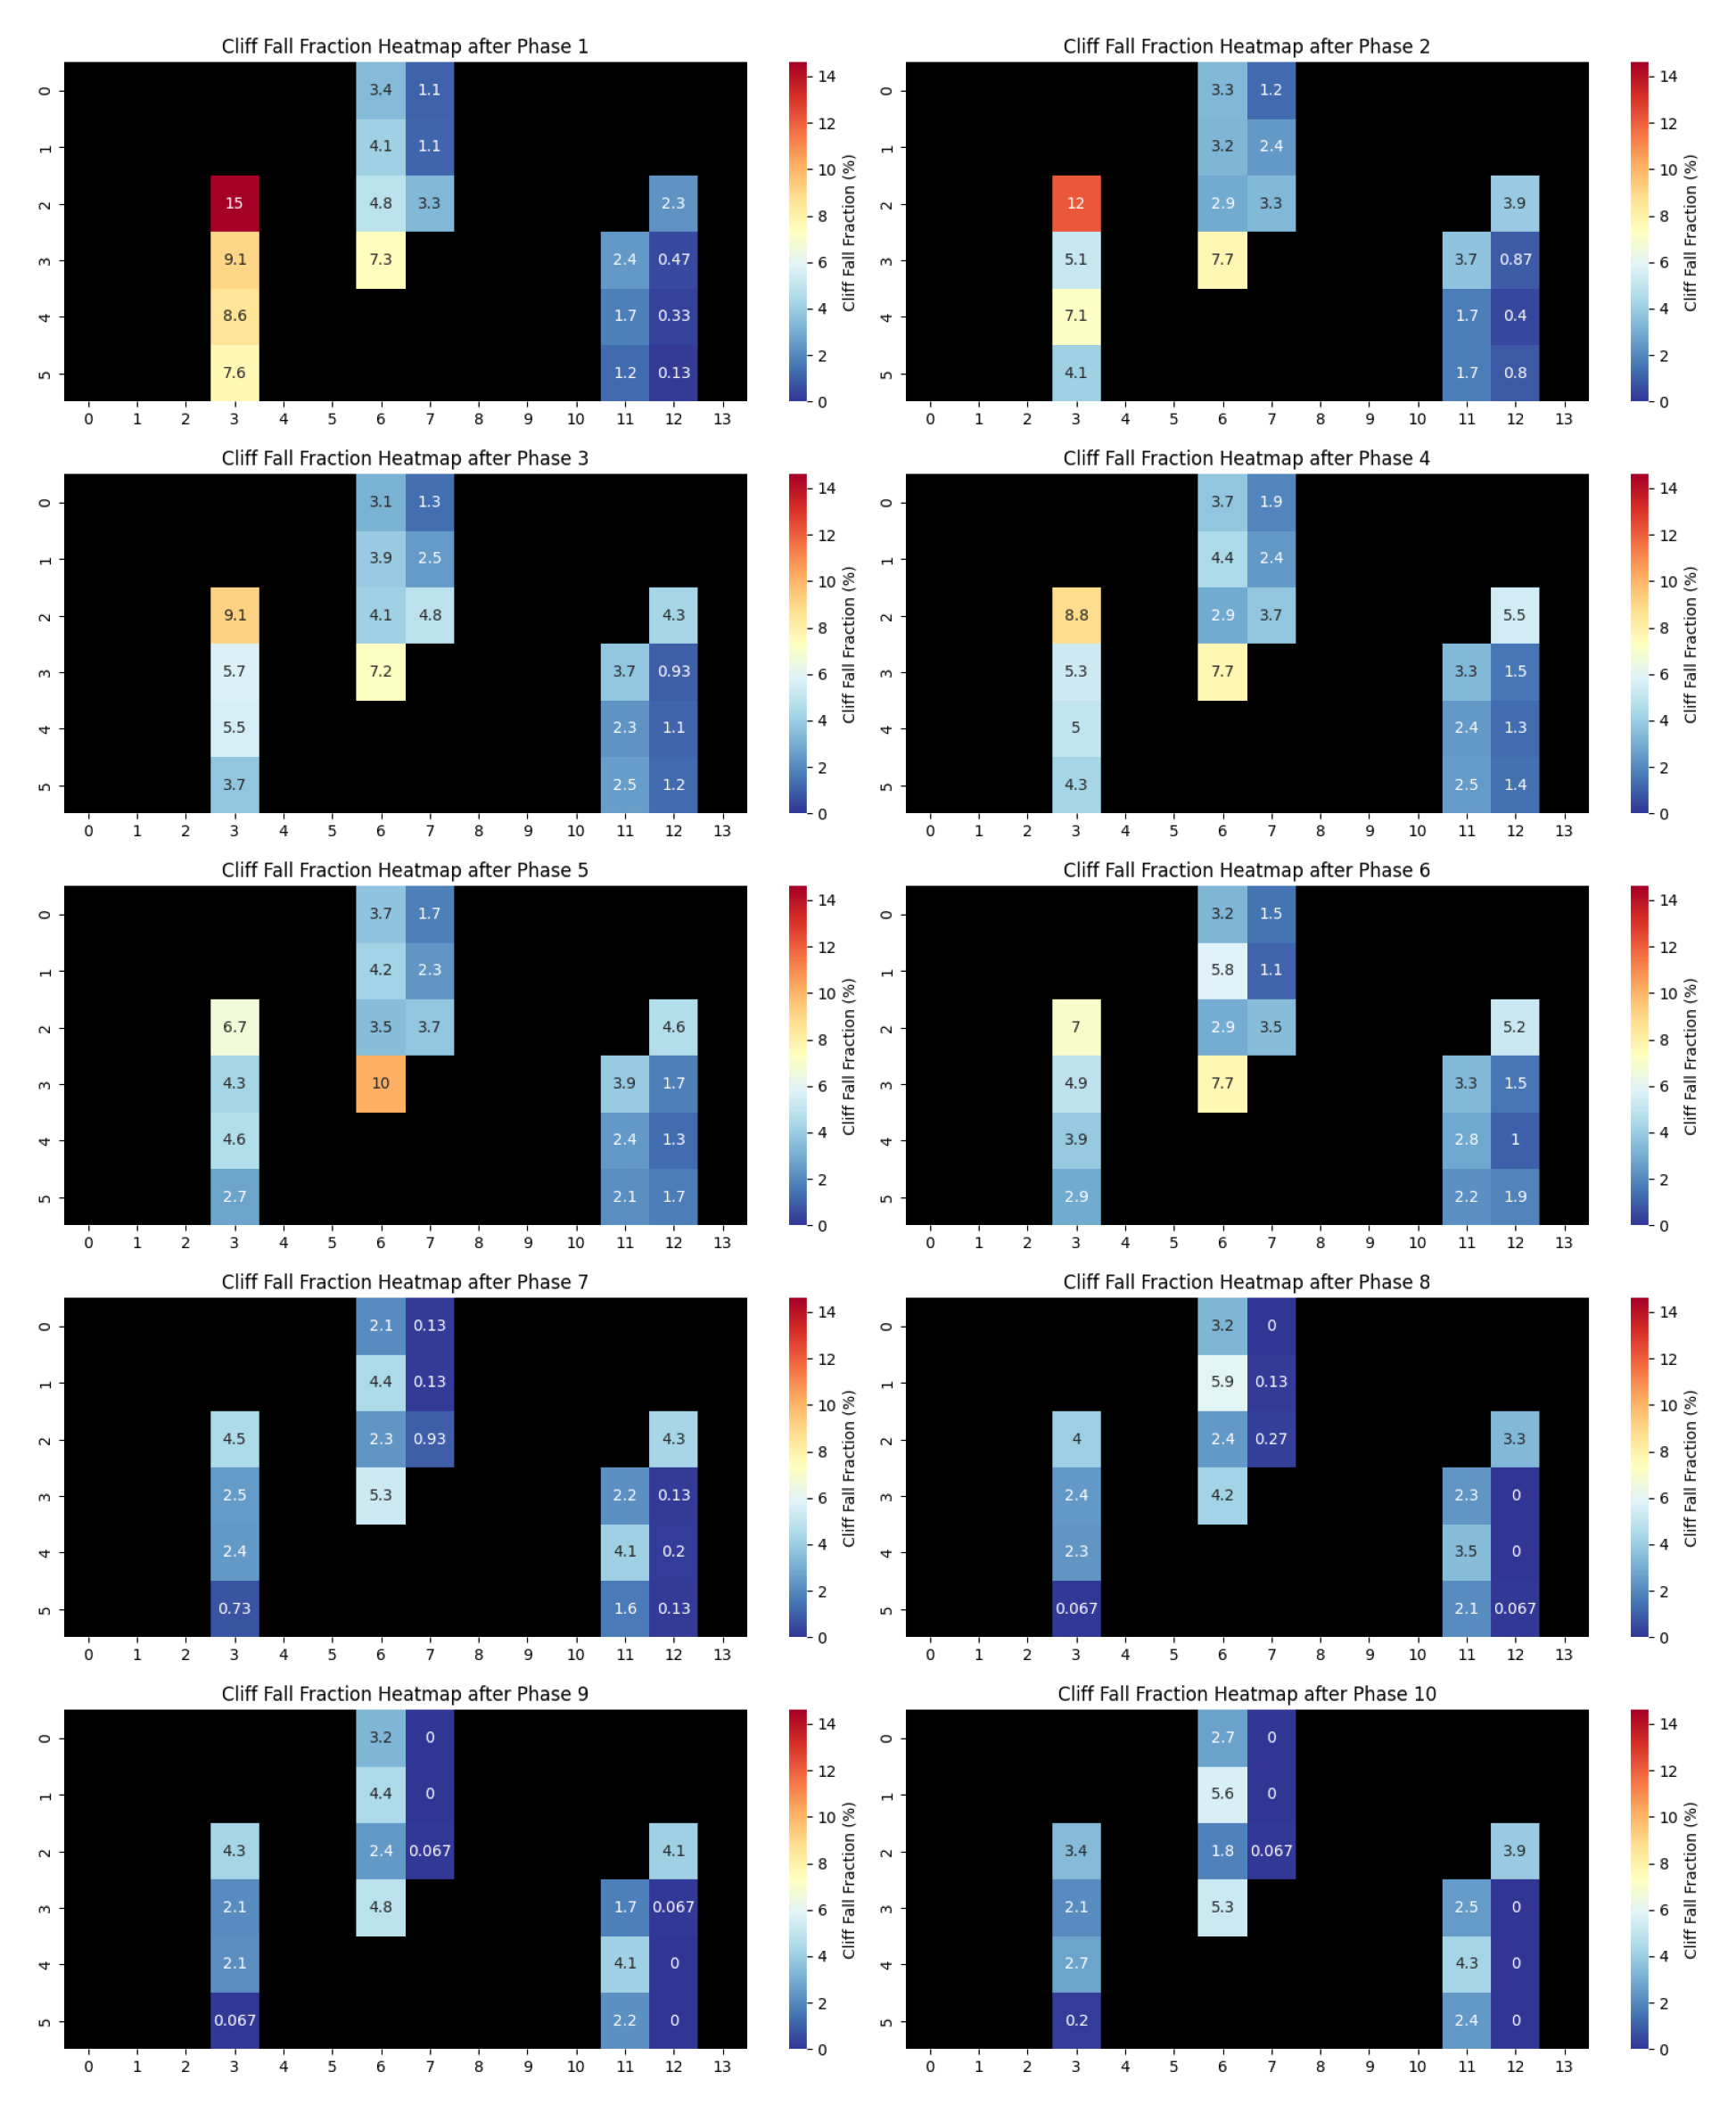

In [14]:
#save results as one big collage
image_files = sorted([os.path.join(output_dir+'/cliff_fall_heatmaps', f) for f in os.listdir(output_dir+'/cliff_fall_heatmaps') if f.endswith((".png"))])
images = [Image.open(f) for f in image_files]

n = len(images)
# rows = cols = math.ceil(math.sqrt(n))  # squa
rows = math.ceil(n / 2)
cols = 2

w, h = images[0].size
collage = Image.new("RGB", (cols * w, rows * h), color="white")

for idx, img in enumerate(images):
    r, c = divmod(idx, cols)
    collage.paste(img, (c * w, r * h))

# Show collage
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(collage)
plt.axis("off")
plt.savefig(f"{output_dir}/cliff_fall_heatmaps_collage.png", bbox_inches="tight")
plt.show()

Add visualization of learned policy

In [15]:
### ASSIGNMENT START

#add custom visualization of learned policy

#initialize environment
env = CliffBoxGridWorld(render=True)
state = env.reset()
done = False
rewards = []

#get the state matrix and convert to integers
world_state = np.char.decode(env.world, "utf-8")
unique_values = np.unique(world_state)
val_to_int = {val: idx for idx, val in enumerate(unique_values)}
cmap = ListedColormap(['lightblue', 'grey', 'green', 'white', 'red'])

plot_state_grid(
    world_state=world_state,
    val_to_int=val_to_int,
    cmap=cmap,
    title=f"Initial State",
    output_path=f'{output_dir}/learned_policy/step_000.png',
)

while not done: 
    #agent takes action based on learned policy
    action = agent.act(state, is_training=False)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    world_state = np.char.decode(env.world, "utf-8")

    plot_state_grid(
        world_state=world_state,
        val_to_int=val_to_int,
        cmap=cmap,
        title=f'Step: {env.timesteps:03}, State: {state}, Actions: {action}, Reward: {reward}',
        output_path=f'{output_dir}/learned_policy/step_{env.timesteps:03}.png',
    )

#plot final state
world_state = np.char.decode(env.world, "utf-8")

plot_state_grid(
    world_state=world_state,
    val_to_int=val_to_int,
    cmap=cmap,
    title=f'Final State at Step: {env.timesteps:03}, Total Reward: {sum(rewards)}',
    output_path=f'{output_dir}/learned_policy/step_terminal.png',
)
### ASSIGNMENT END

/tmp/ipykernel_41486/1052265603.py:55: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  self.world = np.chararray((self.world_height, self.world_width))


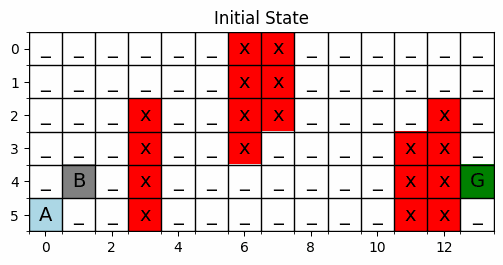

In [16]:
#save results as gif
image_files = sorted([os.path.join(output_dir+'/learned_policy', f) for f in os.listdir(output_dir+'/learned_policy') if f.endswith((".png"))])
images = [Image.open(f) for f in image_files]

gif_path = f"{output_dir}/learned_policy.gif"
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=200,   # ms per frame
    loop=0
)
IPyImage(filename=gif_path)

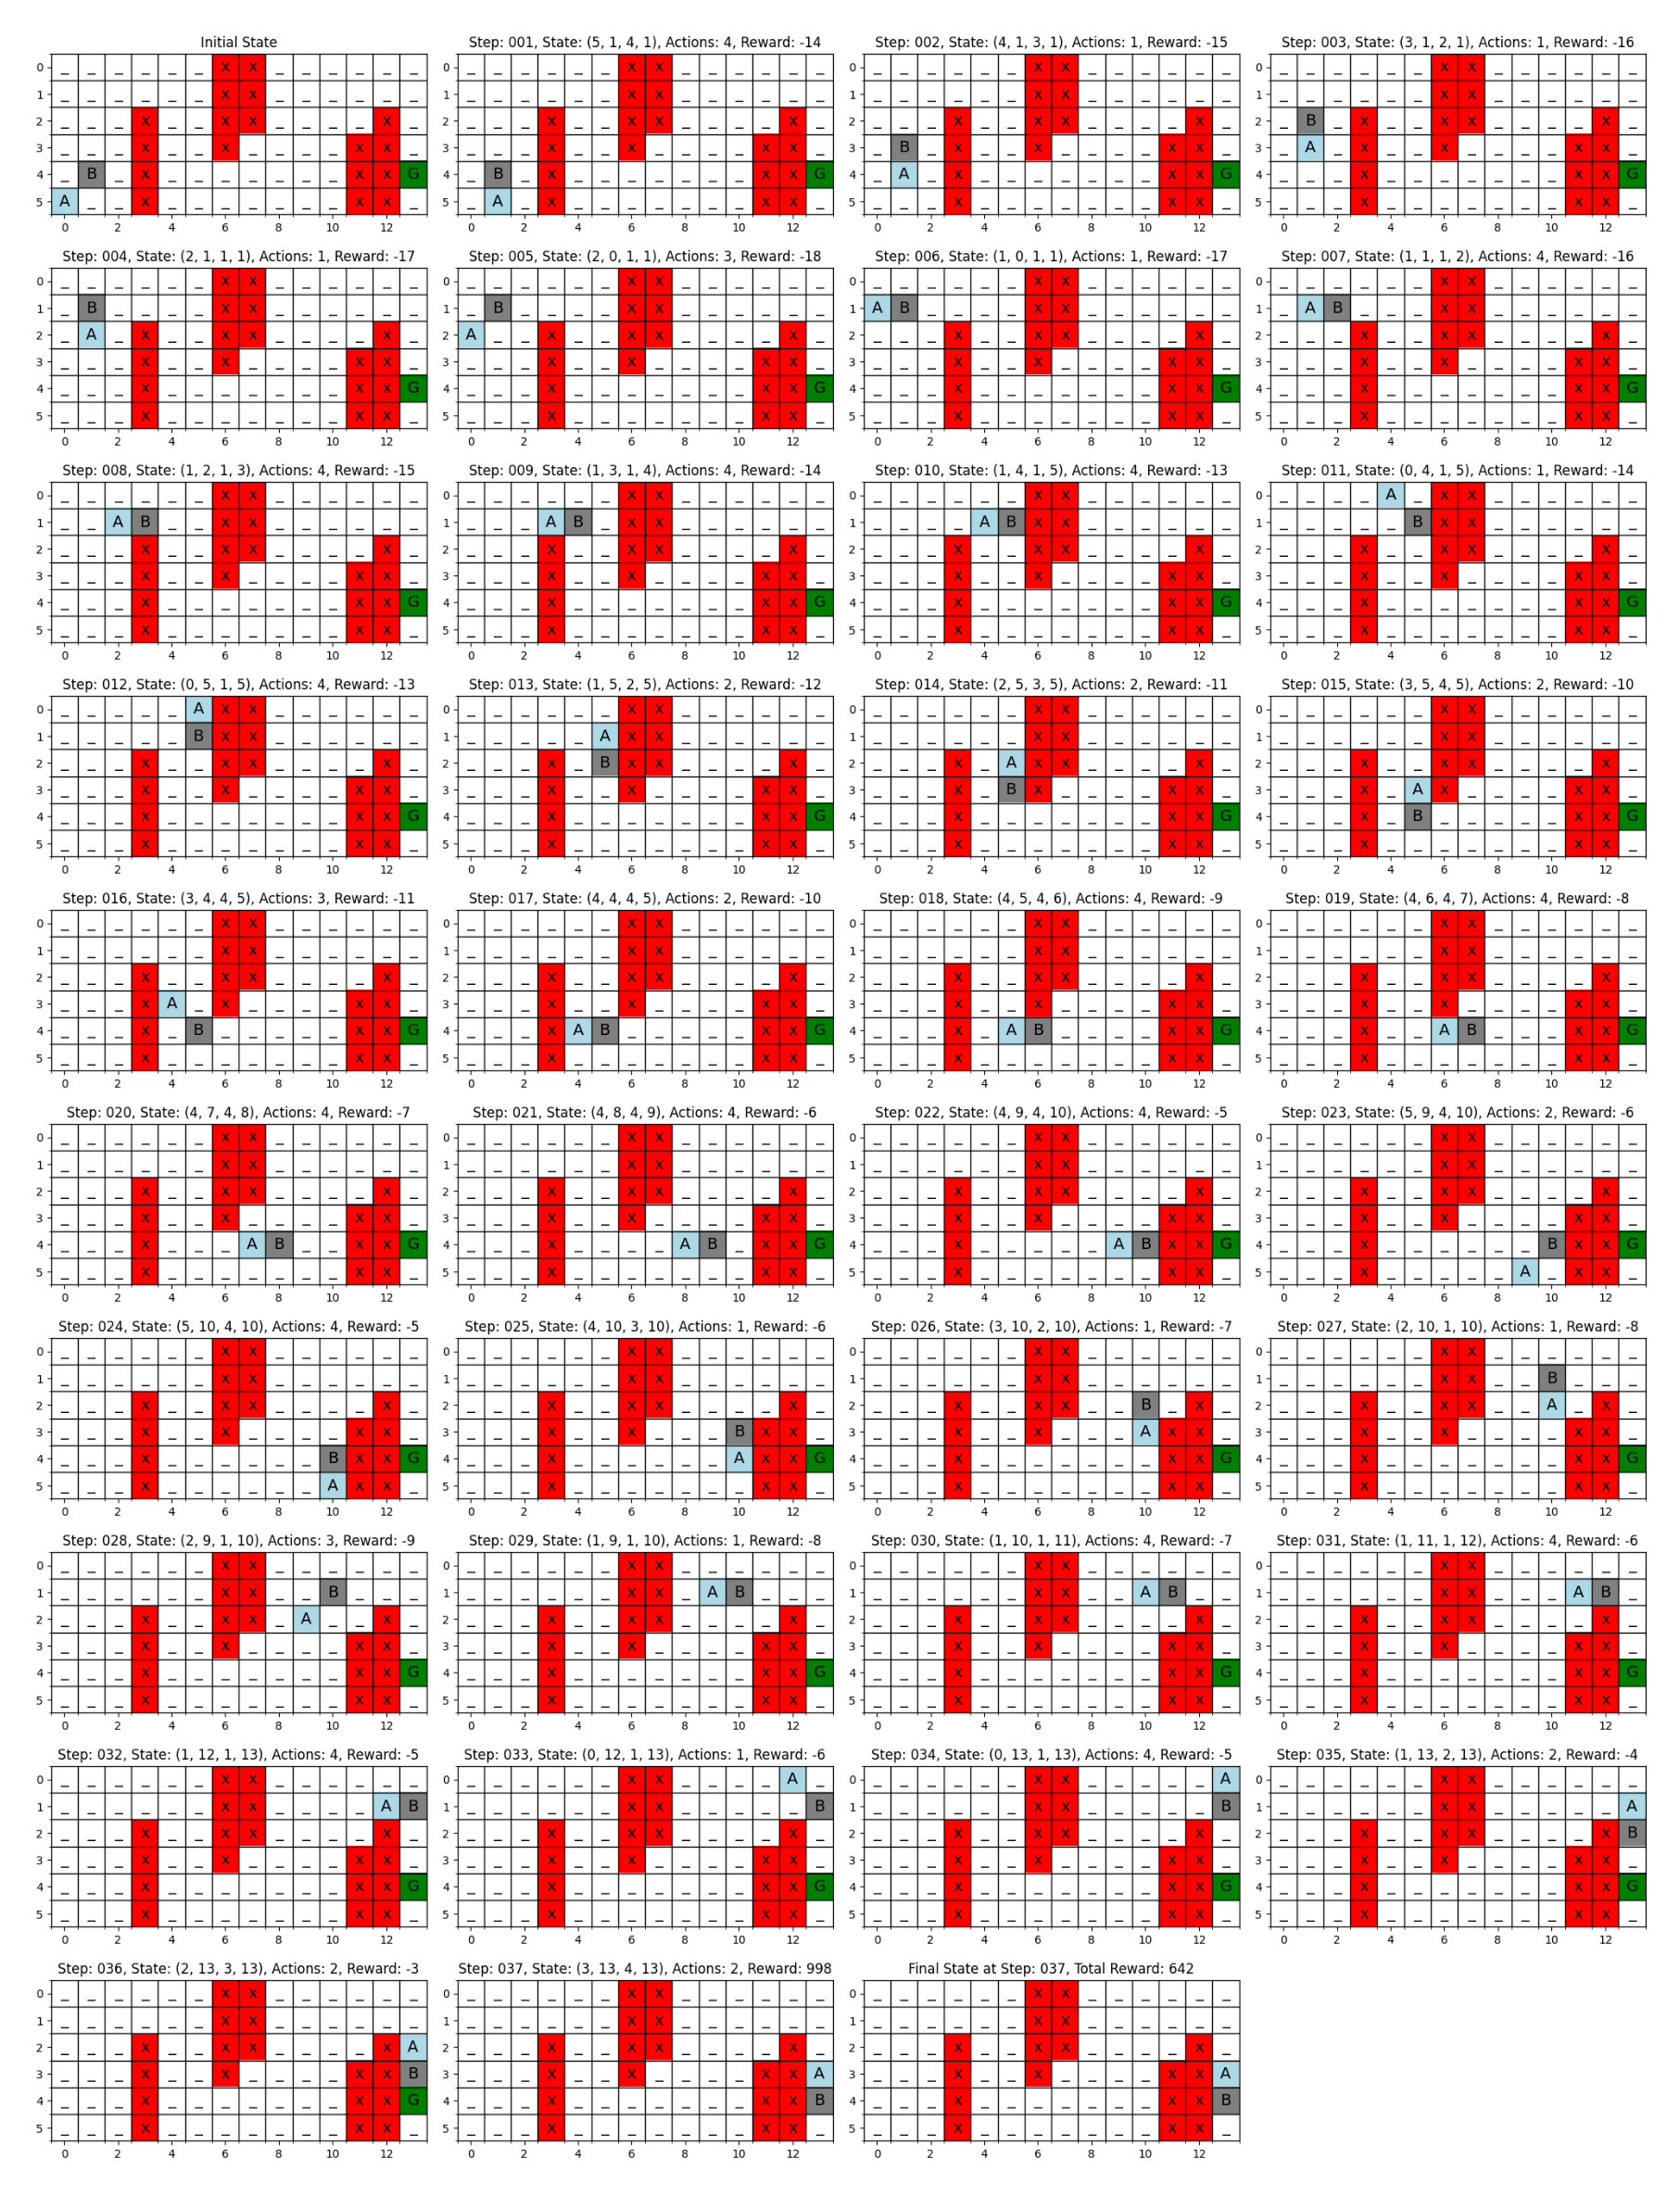

In [17]:
#save results as one big collage
n = len(images)
# rows = cols = math.ceil(math.sqrt(n))  # squa
rows = math.ceil(n / 4)
cols = 4

w, h = images[0].size
collage = Image.new("RGB", (cols * w, rows * h), color="white")

for idx, img in enumerate(images):
    r, c = divmod(idx, cols)
    collage.paste(img, (c * w, r * h))

# Show collage
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(collage)
plt.axis("off")
plt.savefig(f"{output_dir}/learned_policy_collage.png", bbox_inches="tight")
plt.show()